<a href="https://colab.research.google.com/github/jcburtonlab/charged-drops/blob/main/Charged_Drops_Figure_Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.constants import epsilon_0

In [2]:
header_names = ['time', 'charge', 'mass', 'rel_hum', 'temp']
exported_header_names = ['dQ', 'dM', 'timestamp', 'mass jumps', 'plateaus', 'trial']
# Raw .csv and parsed dataframe headers for use with pandas

This `parser_norm` function is used to pull the drop features from trial-generated .csv files, with the returned drop charge, mass, and indicators for those data points. This exported data can be used to analyze a single trial, or is passed into `importer_exporter` to create massive multiple-trial, per-figure datasets.

In [3]:
def parser_norm(filename : str, rate_threshold : float = 0.02,
                header_names = ['time', 'charge', 'mass', 'rel_hum', 'temp'],
                charge_window : int = 6, verbose = 0, ext_end_treatment = False):

    dataframe = pd.read_csv(filename, header = 1, names = header_names)

    masses = dataframe.loc[:, 'mass'].to_numpy(dtype = np.float64)
    charges = dataframe.loc[:, 'charge'].to_numpy(dtype = np.float64)
    times = dataframe.loc[:, 'time'].to_numpy(dtype = np.float64)
    # Converting dataframe columns into numpy vectors for easier manipulation

    if ext_end_treatment:
        masses = np.append(masses, np.ones(80) * masses[-1])
        charges = np.append(charges, np.ones(80) * charges[-1])
        times = np.append(times, np.ones(80) * times[-1])
    # Extending final data points if recording does not feature a tail plateau

    if charges[0] != 0:
        charges -= charges[0]
    else:
        charges[0] = charges[1]
        charges -= charges[0]
    # Treat zero-hop (initial data points may jump to a charge value at the start of recording)

    dm_centraldiff = (masses[2:] - masses[:-2]) / (times[2:] - times[:-2])
    # Use a central difference to find m_dot across the series

    mass_changes = np.where(dm_centraldiff > rate_threshold)[0]
    mass_changes = mass_changes[np.where(times[mass_changes] > 30)]
    # Take mass_changes as a 1D array indicating the time values where m_dot is above a certain threshold value

    fixed_mass_changes = mass_changes[np.where((mass_changes[1:] - mass_changes[:-1]) > 1)]
    fixed_mass_changes = np.append(fixed_mass_changes, mass_changes[-1])
    # Remove neighbor indices from the mass_changes array

    mid_plateau_indices = [int(np.median(fixed_mass_changes[i:i + 2])) + 1 for i in range(len(fixed_mass_changes) - 2) if (fixed_mass_changes[i] > 80)]
    mid_plateau_indices.append(int(np.average(fixed_mass_changes[-2:])))
    mid_plateau_indices.append(fixed_mass_changes[-1] + 25)
    # Determining mid-plateau indices from the found indices of (corrected) mass jumps

    charge_hop_frame = np.zeros((len(fixed_mass_changes), (2*charge_window + 1)))
    delta_qs = np.zeros(len(fixed_mass_changes))

    matched_masses = masses[mid_plateau_indices]

    delta_ms = matched_masses[1:] - matched_masses[:-1]
    delta_ms = np.insert(delta_ms, 0, matched_masses[0])

    for j, value in enumerate(fixed_mass_changes):
        charge_hop_frame[j, :] = charges[(value - charge_window) : (value + charge_window + 1)]
        frame_index = np.abs(np.diff(charge_hop_frame[j, 1:-2])).argmax()
        delta_qs[j] = charge_hop_frame[j][frame_index + 3] - charge_hop_frame[j][frame_index]

    match verbose:
        case 0:
            return delta_qs, delta_ms, times[fixed_mass_changes]
        case 1:
            return delta_qs, delta_ms, times[fixed_mass_changes], fixed_mass_changes, mid_plateau_indices
        case 2:
            return delta_qs, delta_ms, times[fixed_mass_changes], fixed_mass_changes, mid_plateau_indices, charge_hop_frame
        case 3:
            return delta_qs, delta_ms, times[fixed_mass_changes], fixed_mass_changes, mid_plateau_indices, charge_hop_frame, masses[-1] - masses[0], charges[fixed_mass_changes[-1]] - charges[0]

def importerexporter(input_files : list[str], filename : str, treat : bool = False):

    data = pd.DataFrame({'deltaQ (pC)' : [], 'deltaM (g)' : [], 'time (s)' : [],
                            'mass jump indices' : [], 'mid plateau indices' : [],
                            'trial' : []})

    for file in input_files:
        delta_qs, delta_ms, times, fixed_mass_changes, mid_plateau_indices = parser_norm(file, verbose = 1, ext_end_treatment = treat)

        fileframe = pd.DataFrame({'deltaQ (pC)' : delta_qs, 'deltaM (g)' : delta_ms, 'time (s)' : times,
                                'mass jump indices' : fixed_mass_changes, 'mid plateau indices' : mid_plateau_indices,
                                'trial' : [re.split(r'\\', file)[-1]] * len(delta_qs)})
        data = pd.concat([data, fileframe])

    data.to_csv(filename, mode = 'w', header = True, index = False)
    print('Done. Extracted data saved to ' + filename)


In [44]:
github_repo_rawurl = r'https://github.com/jcburtonlab/charged-drops/raw/refs/heads/main/'
# URL stem linking to datasets stored on the Burton Lab GitHub repo

# Paper Figures

In [4]:
colwidth_in = 3.5
# Width for figure generation in reference to paper dimensions

## Fig. 1: Schematic and Recording Example

### Data Import

In [17]:
example_path = github_repo_rawurl + 'exampledata-recording.csv'

example_data = pd.read_csv(example_path, header = 1, names = header_names)

In [20]:
fig2_times = example_data.loc[:, 'time'].to_numpy(dtype = np.float64)
fig2_charges = example_data.loc[:, 'charge'].to_numpy(dtype = np.float64); fig2_charges -= fig2_charges[0] # Adjust for zero-hop
fig2_masses = example_data.loc[:, 'mass'].to_numpy(dtype = np.float64)

example_data_parsed = parser_norm(example_path, verbose = 3)
focal_point = example_data_parsed[4][15]

### Figure Creation

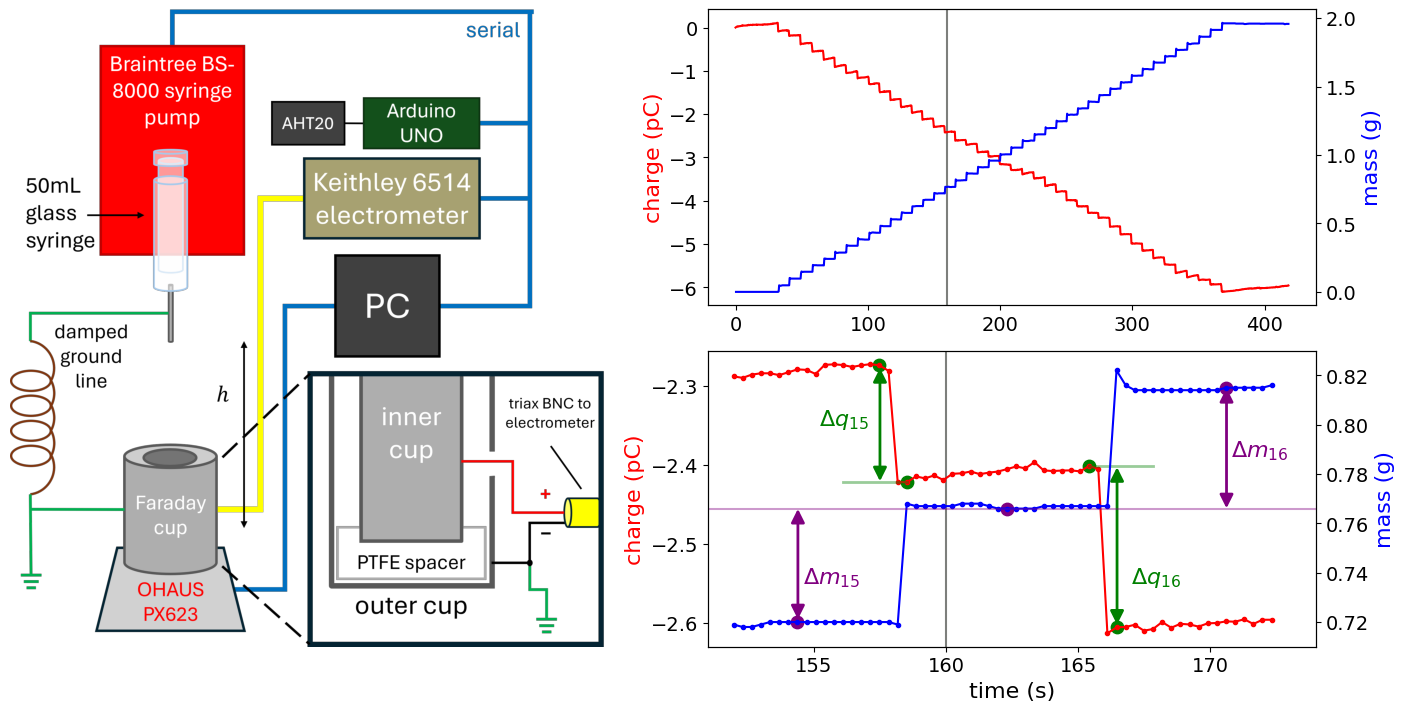

In [25]:
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patchy
from PIL import Image
import requests
from io import BytesIO


annot_textsize, legend_textsize, tick_textsize, label_textsize = 16, 12, 14, 16
dot_size = 80
vline_color = 'xkcd:medium grey'

fig = plt.figure(layout="constrained", figsize = (4 * colwidth_in, 2 * colwidth_in))

gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

## SCHEMATIC

ax1.imshow(Image.open(BytesIO((requests.get(github_repo_rawurl + 'schematic_dgl-nantall.png')).content)))
ax1.axis('off')

## RECORDING: TOP FIGURE

ax2.axvline(160, color = vline_color)

ax2.plot(fig2_times, fig2_charges, 'r')
#ax2.set_xlabel("time (s)", fontsize = label_textsize)
ax2.set_ylabel("charge (pC)", color = 'r', fontsize = label_textsize)
ax2.tick_params(axis='both', labelsize = tick_textsize)

ax_twint = ax2.twinx()
ax_twint.plot(fig2_times, fig2_masses, 'b')
ax_twint.set_xlabel("time (s)", fontsize = label_textsize); ax_twint.set_ylabel("mass (g)", color = 'b', fontsize = label_textsize)
ax_twint.tick_params(axis='y', labelsize = tick_textsize)

## RECORDING: BOTTOM FIGURE, INSET

ax3.axvline(160, color = vline_color)

ax3.plot(fig2_times[focal_point-30 : focal_point+30], fig2_charges[focal_point-30 : focal_point+30], 'r.-')
ax3.set_xlabel("time (s)", fontsize = label_textsize); ax3.set_ylabel("charge (pC)", color = 'r', fontsize = label_textsize)
ax3.tick_params(axis='both', labelsize = tick_textsize)

ax3.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))

ax3.scatter(fig2_times[460], fig2_charges[460], 80, color = 'g')
ax3.scatter(fig2_times[457], fig2_charges[457], 80, color = 'g')

ax3.scatter(fig2_times[483], fig2_charges[483], 80, color = 'g')
ax3.scatter(fig2_times[480], fig2_charges[480], 80, color = 'g')

ax3.plot([fig2_times[453], fig2_times[460]], np.ones(2) * fig2_charges[460], color = 'g', alpha = 0.4, lw = 2)
ax3.plot([fig2_times[480], fig2_times[487]], np.ones(2) * fig2_charges[480], color = 'g', alpha = 0.4, lw = 2)

ax3.add_patch(patchy.FancyArrowPatch((fig2_times[457] + 0.02, fig2_charges[457]),
                                (fig2_times[457] + 0.02, fig2_charges[460] - 0.002),
                                arrowstyle = '<|-|>', mutation_scale=20,
                                color = 'g', lw=2))

ax3.add_patch(patchy.FancyArrowPatch((fig2_times[483] + 0.02, fig2_charges[483]),
                                (fig2_times[483] + 0.02, fig2_charges[480] + 0.002),
                                arrowstyle = '<|-|>', mutation_scale=20,
                                color = 'g', lw=2))

ax_twinb = ax3.twinx()
ax_twinb.plot(fig2_times[focal_point-30 : focal_point+30], fig2_masses[focal_point-30 : focal_point+30], 'b.-')
ax_twinb.set_xlabel("time (s)", fontsize = label_textsize); ax_twinb.set_ylabel("mass (g)", color = 'b', fontsize = label_textsize)
ax_twinb.tick_params(axis='y', labelsize = tick_textsize)
ax_twinb.set_ylim([0.71, 0.83])
ax_twinb.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

ax3.set_xlim([151, 174]); ax_twinb.set_xlim([151, 174])

## BOTTOM FIGURE ANNOTATION FOR DM

ax_twinb.scatter(fig2_times[example_data_parsed[4][14:17]], fig2_masses[example_data_parsed[4][14:17]], dot_size, color = 'purple')
ax_twinb.axhline(0.766, color = 'purple', alpha = 0.4)

ax_twinb.add_patch(patchy.FancyArrowPatch((fig2_times[example_data_parsed[4][14]] + 0.02, fig2_masses[example_data_parsed[4][14]]),
                                (fig2_times[example_data_parsed[4][14]] + 0.02, fig2_masses[example_data_parsed[4][15]] + 0.001),
                                arrowstyle = '<|-|>', mutation_scale=20,
                                color = 'purple', lw=2))

ax_twinb.add_patch(patchy.FancyArrowPatch((fig2_times[example_data_parsed[4][16]] + 0.02, fig2_masses[example_data_parsed[4][15]] - 0.001),
                                (fig2_times[example_data_parsed[4][16]] + 0.02, fig2_masses[example_data_parsed[4][16]] + 0.001),
                                arrowstyle = '<|-|>', mutation_scale=20,
                                color = 'purple', lw=2))

ax3.text(154.6, -2.55, '$\Delta m_{15}$', fontsize = label_textsize, color = 'purple')
ax3.text(170.8, -2.39, '$\Delta m_{16}$', fontsize = label_textsize, color = 'purple')

ax3.text(155.2, -2.35, '$\Delta q_{15}$', fontsize = label_textsize, color = 'g')
ax3.text(167, -2.55, '$\Delta q_{16}$', fontsize = label_textsize, color = 'g')

plt.show()

## Fig. 2: Cage and Air Height-Varied Comparison PDFs

### Data Import

In [27]:
datahv11ga = pd.read_csv(github_repo_rawurl + 'heightvarieddata-stack.csv', header = 1, names = exported_header_names)

qm10cm11ga = datahv11ga.loc[datahv11ga.index[datahv11ga['trial'].str.contains(r'_10cm', na=False)], 'dQ'] / datahv11ga.loc[datahv11ga.index[datahv11ga['trial'].str.contains(r'_10cm', na=False)], 'dM']
qm20cm11ga = datahv11ga.loc[datahv11ga.index[datahv11ga['trial'].str.contains(r'_20cm', na=False)], 'dQ'] / datahv11ga.loc[datahv11ga.index[datahv11ga['trial'].str.contains(r'_20cm', na=False)], 'dM']
qm30cm11ga = datahv11ga.loc[datahv11ga.index[datahv11ga['trial'].str.contains(r'_30cm', na=False)], 'dQ'] / datahv11ga.loc[datahv11ga.index[datahv11ga['trial'].str.contains(r'_30cm', na=False)], 'dM']
qm40cm11ga = datahv11ga.loc[datahv11ga.index[datahv11ga['trial'].str.contains(r'_40cm', na=False)], 'dQ'] / datahv11ga.loc[datahv11ga.index[datahv11ga['trial'].str.contains(r'_40cm', na=False)], 'dM']

In [28]:
datahv11gacaged = pd.read_csv(github_repo_rawurl + 'heightvariedcageddata-stack.csv', header = 1, names = exported_header_names)

qm10cm11gacaged = datahv11gacaged.loc[datahv11gacaged.index[datahv11gacaged['trial'].str.contains(r'_10cm', na=False)], 'dQ'] / datahv11gacaged.loc[datahv11gacaged.index[datahv11gacaged['trial'].str.contains(r'_10cm', na=False)], 'dM']
qm20cm11gacaged = datahv11gacaged.loc[datahv11gacaged.index[datahv11gacaged['trial'].str.contains(r'_20cm', na=False)], 'dQ'] / datahv11gacaged.loc[datahv11gacaged.index[datahv11gacaged['trial'].str.contains(r'_20cm', na=False)], 'dM']
qm30cm11gacaged = datahv11gacaged.loc[datahv11gacaged.index[datahv11gacaged['trial'].str.contains(r'_30cm', na=False)], 'dQ'] / datahv11gacaged.loc[datahv11gacaged.index[datahv11gacaged['trial'].str.contains(r'_30cm', na=False)], 'dM']
qm40cm11gacaged = datahv11gacaged.loc[datahv11gacaged.index[datahv11gacaged['trial'].str.contains(r'_40cm', na=False)], 'dQ'] / datahv11gacaged.loc[datahv11gacaged.index[datahv11gacaged['trial'].str.contains(r'_40cm', na=False)], 'dM']

### Figure Creation

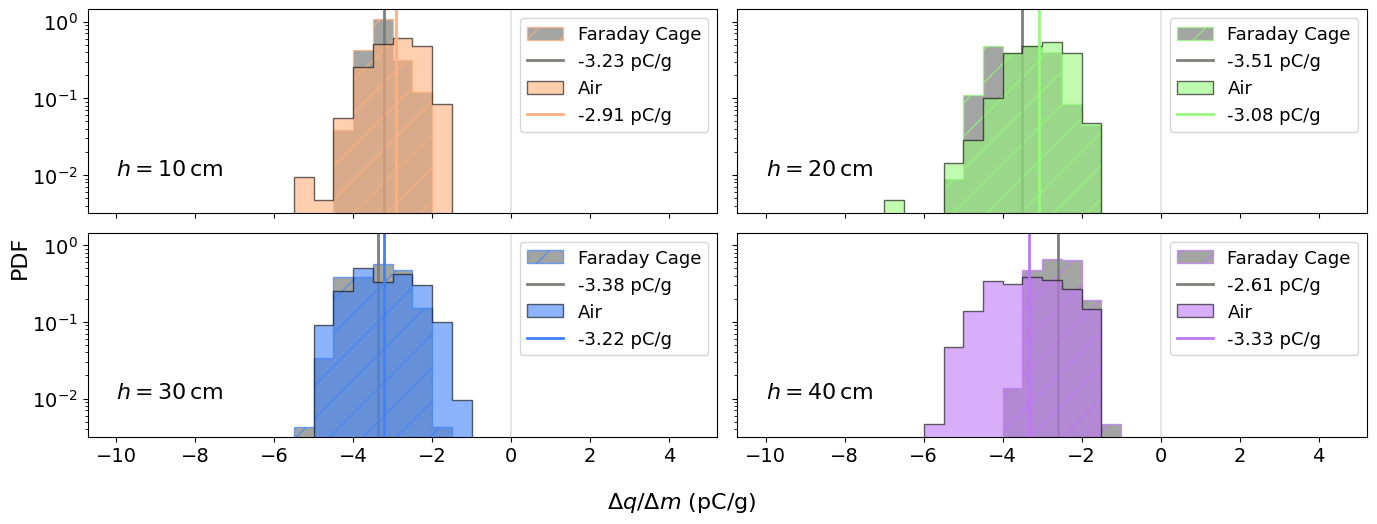

In [29]:
fig, ax = plt.subplots(2, 2, figsize = (4 * colwidth_in, 1.5 * colwidth_in), sharex = True, sharey = True)

bins_vector = np.arange(-10, 5, 0.5)

heightdata = [qm10cm11ga, qm20cm11ga, qm30cm11ga, qm40cm11ga]
heightcagedata = [qm10cm11gacaged, qm20cm11gacaged, qm30cm11gacaged, qm40cm11gacaged]
colors_height = ['xkcd:peach', 'xkcd:light green', 'xkcd:dodger blue', 'xkcd:light purple']

annot_textsize, legend_textsize, tick_textsize, label_textsize = 16, 13, 14, 16

for i in range(2):
    ax[0][i].hist(heightcagedata[i],
               bins = bins_vector, histtype = 'step', fill = True, facecolor = 'xkcd:medium gray', edgecolor = colors_height[i], hatch = '/',
               alpha = 0.7, label = 'Faraday Cage', density = True, log = True)
    ax[0][i].axvline(np.average(heightcagedata[i]),
                  color = 'xkcd:medium gray', alpha = 1, lw = 2, label = rf"{np.average(heightcagedata[i]):.2f} pC/g")

    ax[0][i].hist(heightdata[i],
               bins = bins_vector, histtype = 'step', fill = True, facecolor = colors_height[i], edgecolor = 'k',
               alpha = 0.6, label = 'Air', density = True, log = True)

    ax[0][i].axvline(np.average(heightdata[i]),
                  color = colors_height[i], alpha = 1, lw = 2, label = rf"{np.average(heightdata[i]):.2f} pC/g")

    ax[0][i].axvline(0, color = 'k', alpha = 0.1)
    ax[0][i].legend(loc = 1, fontsize = legend_textsize)
    ax[0][i].text(-10, 0.01, '$h=' + str(i + 1) + '0\,$cm', fontsize = annot_textsize)
    ax[0][i].tick_params(axis='both', which='major', labelsize = tick_textsize)

    ax[1][i].hist(heightcagedata[i + 2],
               bins = bins_vector, histtype = 'step', fill = True, facecolor = 'xkcd:medium gray', edgecolor = colors_height[i + 2], hatch = '/',
               alpha = 0.7, label = 'Faraday Cage', density = True, log = True)
    ax[1][i].axvline(np.average(heightcagedata[i + 2]),
                  color = 'xkcd:medium gray', alpha = 1, lw = 2, label = rf"{np.average(heightcagedata[i + 2]):.2f} pC/g")

    ax[1][i].hist(heightdata[i + 2],
               bins = bins_vector, histtype = 'step', fill = True, facecolor = colors_height[i + 2], edgecolor = 'k',
               alpha = 0.6, label = 'Air', density = True, log = True)

    ax[1][i].axvline(np.average(heightdata[i + 2]),
                  color = colors_height[i + 2], alpha = 1, lw = 2, label = rf"{np.average(heightdata[i + 2]):.2f} pC/g")

    ax[1][i].axvline(0, color = 'k', alpha = 0.1)
    ax[1][i].legend(loc = 1, fontsize = legend_textsize)
    ax[1][i].text(-10, 0.01, '$h=' + str(i + 3) + '0\,$cm', fontsize = annot_textsize)
    ax[1][i].tick_params(axis='both', which='major', labelsize = tick_textsize)

fig.supxlabel('$\Delta q / \Delta m$ (pC/g)', fontsize = label_textsize)
fig.supylabel('PDF', fontsize = label_textsize)

plt.tight_layout()
plt.show()

## Fig. 3: Cleaning Method Comparison PDFs

### Data Import

In [30]:
ethcleandataset = pd.read_csv(github_repo_rawurl + 'ethanolcleaneddata-stack.csv', header = 1, names = exported_header_names)

ethcleancharges = ethcleandataset.iloc[:, 0].to_numpy(dtype = np.float64)
ethcleanmasses = ethcleandataset.iloc[:, 1].to_numpy(dtype = np.float64)

ethcleanpdfvals = ethcleancharges / ethcleanmasses

neutrcleandataset = pd.read_csv(github_repo_rawurl + 'neutradcleaneddata-stack.csv', header = 1, names = exported_header_names)

neutrcleancharges = neutrcleandataset.iloc[:, 0].to_numpy(dtype = np.float64)
neutrcleanmasses = neutrcleandataset.iloc[:, 1].to_numpy(dtype = np.float64)

neutrcleanpdfvals = neutrcleancharges / neutrcleanmasses

plascleandataset = pd.read_csv(github_repo_rawurl + 'plasmacleaneddata-stack.csv', header = 1, names = exported_header_names)

plascleancharges = plascleandataset.iloc[:, 0].to_numpy(dtype = np.float64)
plascleanmasses = plascleandataset.iloc[:, 1].to_numpy(dtype = np.float64)

plascleanpdfvals = plascleancharges / plascleanmasses

### Figure Creation

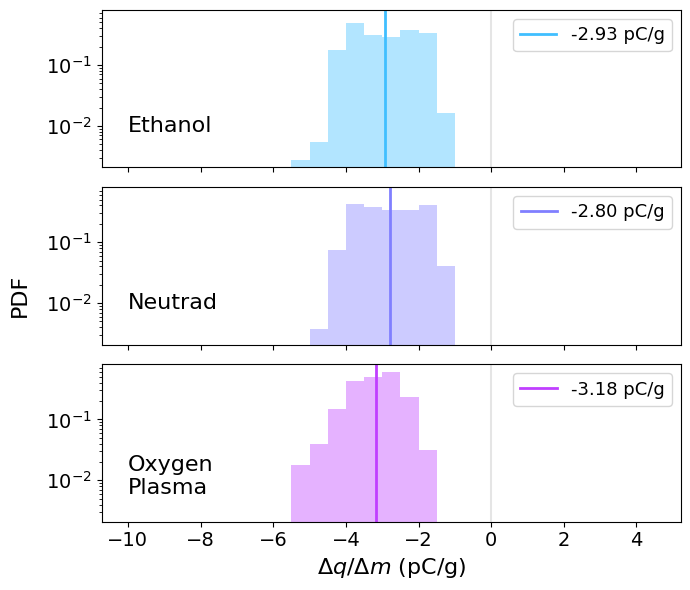

In [31]:
fig, ax = plt.subplots(3, 1, figsize = (2* colwidth_in, 6), sharex = True, sharey = True)

bins_vector = np.arange(-10, 5, 0.5)

annot_textsize, legend_textsize, tick_textsize, label_textsize = 16, 13, 14, 16

values = [ethcleanpdfvals, neutrcleanpdfvals, plascleanpdfvals]
text_labels_cleaning = ['Ethanol', 'Neutrad', 'Oxygen\nPlasma']

colors_cleaning = (matplotlib.colormaps['cool'])([0.25, 0.5, 0.75])

for i in range(3):
    ax[i].hist(values[i], bins = bins_vector, color = colors_cleaning[i], alpha = 0.4, density = True, log = True)
    ax[i].axvline(np.average(values[i]), color = colors_cleaning[i], alpha = 1, lw = 2,
                label = rf"{np.average(values[i]):.2f} pC/g")

    ax[i].axvline(0, color = 'k', alpha = 0.1)
    ax[i].legend(loc = 1, fontsize = legend_textsize)
    ax[i].text(-10, 0.006 if i == 2 else 0.008, text_labels_cleaning[i], fontsize = annot_textsize)
    ax[i].tick_params(axis='both', which='major', labelsize = tick_textsize)

plt.xlabel('$\Delta q / \Delta m$ (pC/g)', fontsize = label_textsize)
fig.supylabel('PDF', fontsize = label_textsize)

plt.tight_layout()
plt.show()

## Fig. 4: Bias Voltage on Metal Tips

### Data Import

In [35]:
biasedSSdataset = pd.read_csv(github_repo_rawurl + 'biasedSStipdata-stack.csv')
biasedNidataset = pd.read_csv(github_repo_rawurl + 'biasedNitipdata-stack.csv')

In [36]:
# Step 1: Extract bias voltage from trial column of dataset
biasedSSdataset['bias_voltage'] = biasedSSdataset['trial'].apply(lambda x: re.search(r'([-n]?\d+(\.\d+)?V)', x).group(1))
biasedNidataset['bias_voltage'] = biasedNidataset['trial'].apply(lambda x: re.search(r'([-n]?\d+(\.\d+)?V)', x).group(1))

# Step 2: Convert 'n' to '-' for negative voltages (if applicable)
biasedSSdataset['bias_voltage'] = biasedSSdataset['bias_voltage'].str.replace('n', '-', regex=False)
biasedNidataset['bias_voltage'] = biasedNidataset['bias_voltage'].str.replace('n', '-', regex=False)

# Step 3: Group by bias voltage
groupedSSset = biasedSSdataset.groupby('bias_voltage')
groupedNiset = biasedNidataset.groupby('bias_voltage')

In [42]:
plotdatavals_SSbias = np.zeros((2, len(np.arange(-5, 5.5, 0.5))))
plotdatavals_Nibias = np.zeros((2, len(np.arange(-5, 5.5, 0.5))))

for index, voltage_value in enumerate(np.arange(-5, 5.5, 0.5)):
    if voltage_value in [1, 1.5]:
        plotdatavals_SSbias[:, index] = np.nan
        plotdatavals_Nibias[:, index] = np.nan
        continue

    filteredSSset = groupedSSset.get_group(str(voltage_value if voltage_value % 1 != 0 else int(voltage_value)) + 'V')
    filteredSSdQ = filteredSSset.iloc[:, 0].to_numpy(dtype = np.float64)
    filteredSSdM = filteredSSset.iloc[:, 1].to_numpy(dtype = np.float64)

    filteredNiset = groupedNiset.get_group(str(voltage_value if voltage_value % 1 != 0 else int(voltage_value)) + 'V')
    filteredNidQ = filteredNiset.iloc[:, 0].to_numpy(dtype = np.float64)
    filteredNidM = filteredNiset.iloc[:, 1].to_numpy(dtype = np.float64)

    filteredSSdropV = (filteredSSdQ * 1e-12) / (4 * np.pi * epsilon_0 * (((3 * (filteredSSdM / 1000)) / (1000 * 4 * np.pi)) ** (1.0 / 3)))
    filteredNidropV = (filteredNidQ * 1e-12) / (4 * np.pi * epsilon_0 * (((3 * (filteredNidM / 1000)) / (1000 * 4 * np.pi)) ** (1.0 / 3)))
    # Calculate drop voltage per Eq. 1

    plotdatavals_SSbias[0, index], plotdatavals_SSbias[1, index] = np.average(filteredSSdropV), np.std(filteredSSdropV)
    plotdatavals_Nibias[0, index], plotdatavals_Nibias[1, index] = np.average(filteredNidropV), np.std(filteredNidropV)

print('Stainless Steel: V_drop and V_drop err\n', plotdatavals_SSbias, '\n\n', 'Nickel: V_drop and V_drop err\n', plotdatavals_Nibias)

Stainless Steel: V_drop and V_drop err
 [[-3.7334532  -3.59260136 -3.31512342 -3.00014878 -2.6929091  -2.3580922
  -2.02114758 -1.63470752 -1.31219937 -0.94054733 -0.62368664 -0.36754317
          nan         nan  0.66816875  1.00374407  1.30213491  1.66880666
   1.99132475  2.3111599   2.72778158]
 [ 0.11483803  0.11919343  0.12599447  0.14657522  0.12915062  0.1181562
   0.0982893   0.08565233  0.08959339  0.08583113  0.0871204   0.07265007
          nan         nan  0.07321107  0.08113444  0.09626145  0.09865595
   0.11095651  0.09186612  0.13027399]] 

 Nickel: V_drop and V_drop err
 [[-3.45525174 -2.9346907  -2.50151552 -2.36282385 -2.062663   -1.76652665
  -1.60404032 -1.53168402 -1.17873393 -0.80158863 -0.53446144  0.24405737
          nan         nan  0.78605035  1.16126829  1.39391678  1.64268614
   2.10587509  2.55094972  2.32681641]
 [ 0.34535782  0.36970713  0.31600864  0.26240397  0.30803054  0.29838206
   0.24327324  0.2356761   0.19149603  0.17660193  0.16000435  0.26578

In [40]:
from scipy.optimize import curve_fit

paramsSS, covarianceSS = curve_fit(lambda x, m, b: m * x + b, np.arange(-5, 5.5, 0.5)[~np.isnan(plotdatavals_SSbias[0])], plotdatavals_SSbias[0, ~np.isnan(plotdatavals_SSbias[0])])
paramsNi, covarianceNi = curve_fit(lambda x, m, b: m * x + b, np.arange(-5, 5.5, 0.5)[~np.isnan(plotdatavals_Nibias[0])], plotdatavals_Nibias[0, ~np.isnan(plotdatavals_Nibias[0])])

# Extract the best-fit values for m (slope) and b (intercept) for each tip
slopeSS, interceptSS = paramsSS
slopeNi, interceptNi = paramsNi

y_predSS = slopeSS * np.arange(-5, 5.5, 0.5)[~np.isnan(plotdatavals_SSbias[0])] + interceptSS

# Calculate R^2 for Stainless Steel
ss_resSS = np.sum((plotdatavals_SSbias[0, ~np.isnan(plotdatavals_SSbias[0])] - y_predSS) ** 2)  # Residual sum of squares
ss_totSS = np.sum((plotdatavals_SSbias[0, ~np.isnan(plotdatavals_SSbias[0])] - np.mean(plotdatavals_SSbias[0, ~np.isnan(plotdatavals_SSbias[0])])) ** 2)  # Total sum of squares
r_squaredSS = 1 - (ss_resSS / ss_totSS)

y_predNi = slopeNi * np.arange(-5, 5.5, 0.5)[~np.isnan(plotdatavals_Nibias[0])] + interceptNi

# Calculate R^2 for Nickel-Plated
ss_resNi = np.sum((plotdatavals_Nibias[0, ~np.isnan(plotdatavals_Nibias[0])] - y_predNi) ** 2)  # Residual sum of squares
ss_totNi = np.sum((plotdatavals_Nibias[0, ~np.isnan(plotdatavals_Nibias[0])] - np.mean(plotdatavals_Nibias[0, ~np.isnan(plotdatavals_Nibias[0])])) ** 2)  # Total sum of squares
r_squaredNi = 1 - (ss_resNi / ss_totNi)

print(slopeSS, interceptSS, slopeNi, interceptNi, r_squaredSS, r_squaredNi)

0.658623801481227 -0.6459199770541861 0.5896203539646356 -0.37096361957374535 0.9991383364751274 0.9920616776619262


### Figure Creation

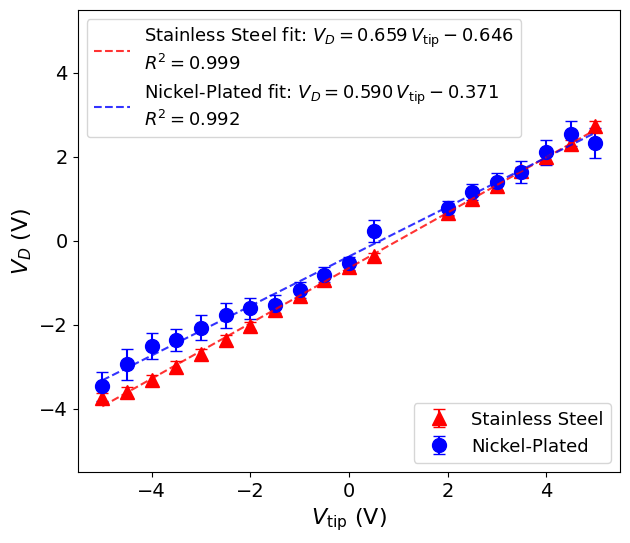

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (2* colwidth_in, 6), sharex = True, sharey = True)

appliedvoltages = np.arange(-5, 5.5, 0.5)
yrange = [-5.5, 5.5]; xrange = [-5.5, 5.5]

annot_textsize, legend_textsize, tick_textsize, label_textsize = 16, 13, 14, 16

ax.errorbar(appliedvoltages, plotdatavals_SSbias[0], plotdatavals_SSbias[1], None, 'r^', markersize = 10,
            label = 'Stainless Steel', capsize = 4)
ax.errorbar(appliedvoltages, plotdatavals_Nibias[0], plotdatavals_Nibias[1], None, 'bo', markersize = 10,
            label = 'Nickel-Plated', capsize = 4)

axt = ax.twinx()

axt.plot(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100) * slopeSS + interceptSS, 'r--',
        alpha = 0.8, label = f'Stainless Steel fit: $V_D={slopeSS:.3f}\\,V_\\text{{tip}}{interceptSS:+.3f}$\n$R^2={r_squaredSS:.3f}$')

axt.plot(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100) * slopeNi + interceptNi, 'b--',
        alpha = 0.8, label = f'Nickel-Plated fit: $V_D={slopeNi:.3f}\\,V_\\text{{tip}}{interceptNi:+.3f}$\n$R^2={r_squaredNi:.3f}$')

for axes in [ax, axt]:
    axes.set_xlim(xrange); axes.set_ylim(yrange)
    axes.legend(loc = 4 if axes == ax else 2, fontsize = legend_textsize)

    if axes == ax:
        axes.tick_params(axis='both', which='major', labelsize = tick_textsize)
        axes.set_xlabel('$V_\\text{tip}$ (V)', fontsize = label_textsize)
        axes.set_ylabel('$V_D$ (V)', fontsize = label_textsize)
    else:
        axes.axis('off')

plt.show()

## Fig 5: Fluids Comparison

### Data Import

In [32]:
fluorinertdataset = pd.read_csv(github_repo_rawurl + 'fluorinertfluiddata-stack.csv', header = 1, names = exported_header_names)

fluorcharges = fluorinertdataset.iloc[:, 0].to_numpy(dtype = np.float64)
fluormasses = fluorinertdataset.iloc[:, 1].to_numpy(dtype = np.float64)

fluorpdfvals = fluorcharges / fluormasses

glycdataset = pd.read_csv(github_repo_rawurl + 'glycerolfluiddata-stack.csv', header = 1, names = exported_header_names)

glyccharges = glycdataset.iloc[:, 0].to_numpy(dtype = np.float64)
glycmasses = glycdataset.iloc[:, 1].to_numpy(dtype = np.float64)

glycpdfvals = glyccharges / glycmasses

nacldataset = pd.read_csv(github_repo_rawurl + 'naclfluiddata-stack.csv', header = 1, names = exported_header_names)

naclcharges = nacldataset.iloc[:, 0].to_numpy(dtype = np.float64)
naclmasses = nacldataset.iloc[:, 1].to_numpy(dtype = np.float64)

naclpdfvals = naclcharges / naclmasses

### Figure Creation

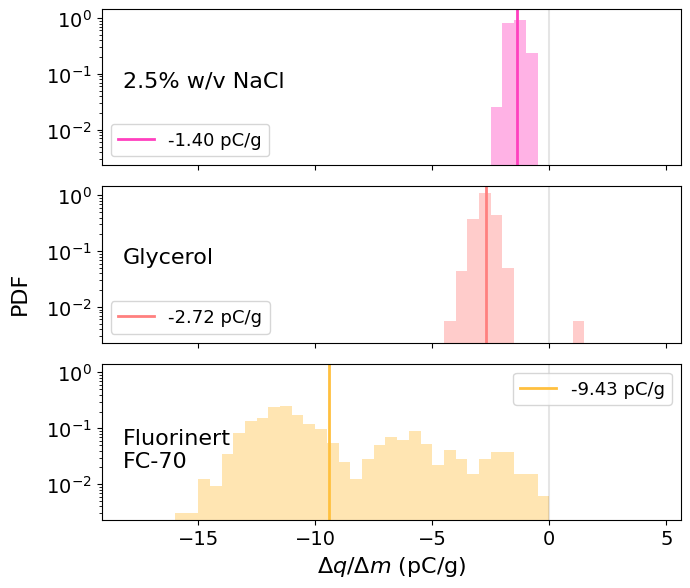

In [34]:
fig, ax = plt.subplots(3, 1, figsize = (2* colwidth_in, 6), sharex = True, sharey = True)

bins_vector = np.arange(-18, 5, 0.5)

annot_textsize, legend_textsize, tick_textsize, label_textsize = 16, 13, 14, 16

values = [naclpdfvals, glycpdfvals, fluorpdfvals]
text_labels_cleaning = ['2.5% w/v NaCl', 'Glycerol', 'Fluorinert\nFC-70']

colors_fluid = (matplotlib.colormaps['spring'])([0.25, 0.5, 0.75])

for i in range(3):
    ax[i].hist(values[i], bins = bins_vector, color = colors_fluid[i], alpha = 0.4, density = True, log = True)
    ax[i].axvline(np.average(values[i]), color = colors_fluid[i], alpha = 1, lw = 2,
                label = rf"{np.average(values[i]):.2f} pC/g")

    ax[i].axvline(0, color = 'k', alpha = 0.1)
    ax[i].legend(loc = 1 if i == 2 else 3, fontsize = legend_textsize)
    ax[i].text(-18.2, 0.02 if i == 2 else 0.06, text_labels_cleaning[i], fontsize = annot_textsize)
    ax[i].tick_params(axis='both', which='major', labelsize = tick_textsize)


plt.xlabel('$\Delta q / \Delta m$ (pC/g)', fontsize = label_textsize)
fig.supylabel('PDF', fontsize = label_textsize)

plt.tight_layout()
plt.show()

## Fig. 6: Plastic Introduction Trial Variations

### Data Import

In [46]:
folder_extended_url = github_repo_rawurl + 'Trial%20Variation%20Recordings/'

uncaged2cmPTFEtips_fnames = ['1204_350ulm_sfnewg_16gaPTFEnew-2cm_15mL.csv',
                             '1204_350ulm_sfnewg_16gaPTFEnew-2cm2_15mL.csv',
                             '1204_350ulm_sfnewg_16gaPTFEnew-2cm3_15mL.csv']

uncagedPPLplast_fnames = ['1216_350ulm_sfnewg_14gaPPLplastn1_10cm-15mL-01.csv',
                          '1216_350ulm_sfnewg_14gaPPLplastn2_10cm-15mL-01.csv',
                          '1216_350ulm_sfnewg_14gaPPLplastn3_10cm-15mL-01.csv']

uncagedmetaltips_fnames = ['1219_350ulm_sfnewg_10gaSS5cm_10cm-15mL-03.csv',
                           '1218_350ulm_sfnewg_10gaSS1cm_10cm-15mL-02.csv',
                           '1219_350ulm_sfnewg_10gaNi5cm_10cm-15mL-01.csv']


### Figure Creation

<ipython-input-3-1cd89d2c758c>:25: RuntimeWarning: invalid value encountered in divide
  dm_centraldiff = (masses[2:] - masses[:-2]) / (times[2:] - times[:-2])
<ipython-input-3-1cd89d2c758c>:25: RuntimeWarning: invalid value encountered in divide
  dm_centraldiff = (masses[2:] - masses[:-2]) / (times[2:] - times[:-2])


Subplot 0 Trial 0: -2.503, 0.668 mean, std
Subplot 0 Trial 1: -1.895, 0.456 mean, std


<ipython-input-3-1cd89d2c758c>:25: RuntimeWarning: invalid value encountered in divide
  dm_centraldiff = (masses[2:] - masses[:-2]) / (times[2:] - times[:-2])


Subplot 0 Trial 2: -2.517, 0.688 mean, std


<ipython-input-3-1cd89d2c758c>:25: RuntimeWarning: invalid value encountered in divide
  dm_centraldiff = (masses[2:] - masses[:-2]) / (times[2:] - times[:-2])
<ipython-input-3-1cd89d2c758c>:25: RuntimeWarning: invalid value encountered in divide
  dm_centraldiff = (masses[2:] - masses[:-2]) / (times[2:] - times[:-2])
<ipython-input-3-1cd89d2c758c>:25: RuntimeWarning: invalid value encountered in divide
  dm_centraldiff = (masses[2:] - masses[:-2]) / (times[2:] - times[:-2])


Subplot 1 Trial 0: 10.969, 1.906 mean, std
Subplot 1 Trial 1: 27.677, 10.454 mean, std
Subplot 1 Trial 2: 38.220, 9.071 mean, std


<ipython-input-3-1cd89d2c758c>:25: RuntimeWarning: invalid value encountered in divide
  dm_centraldiff = (masses[2:] - masses[:-2]) / (times[2:] - times[:-2])
<ipython-input-3-1cd89d2c758c>:25: RuntimeWarning: invalid value encountered in divide
  dm_centraldiff = (masses[2:] - masses[:-2]) / (times[2:] - times[:-2])


Subplot 2 Trial 0: -52.809, 27.826 mean, std
Subplot 2 Trial 1: 71.523, 11.586 mean, std
Subplot 2 Trial 2: 13.198, 10.001 mean, std


<ipython-input-3-1cd89d2c758c>:25: RuntimeWarning: invalid value encountered in divide
  dm_centraldiff = (masses[2:] - masses[:-2]) / (times[2:] - times[:-2])


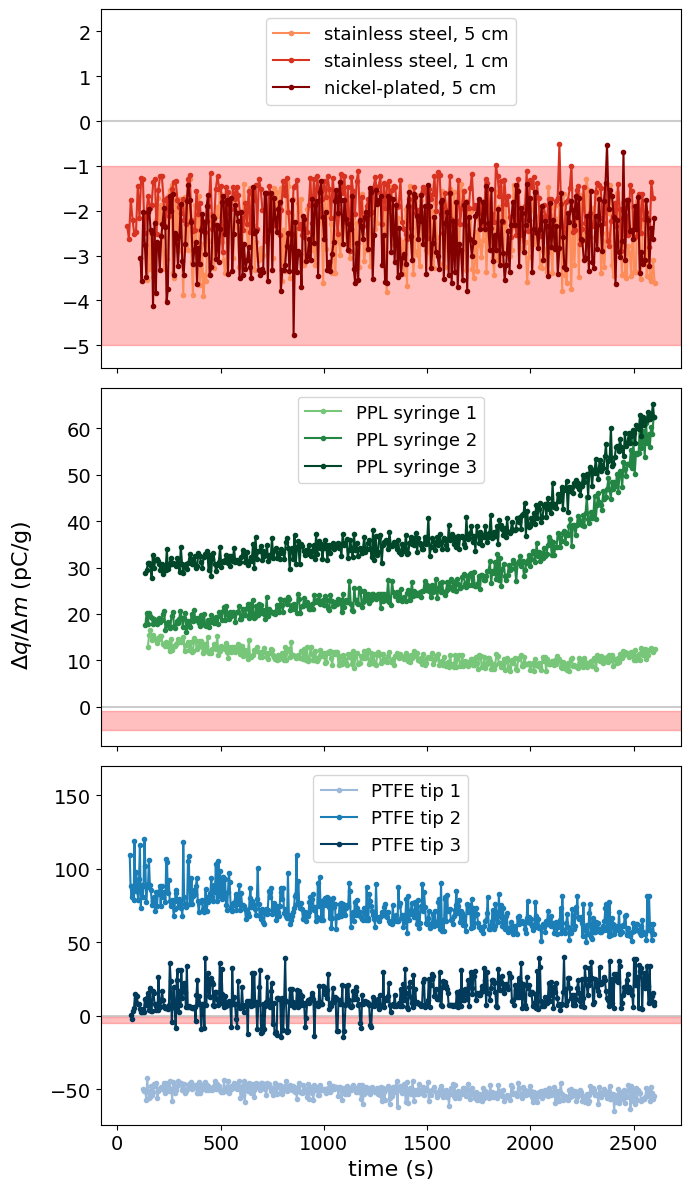

In [50]:
fig, ax = plt.subplots(3, 1, figsize = (2 * colwidth_in, 12), sharex = True, sharey = False)

colors_Mtips = (matplotlib.colormaps['OrRd'])(np.linspace(0.5, 0.99, 3))
colors_PPLtips = (matplotlib.colormaps['YlGn'])(np.linspace(0.5, 0.99, 3))
colors_PTFEtips = (matplotlib.colormaps['PuBu'])(np.linspace(0.4, 0.99, 3))

annot_textsize, legend_textsize, tick_textsize, label_textsize = 16, 13, 14, 16

starter = [1, 15, 1]
colors = [colors_Mtips, colors_PPLtips, colors_PTFEtips]
labels = [['stainless steel, 5 cm', 'stainless steel, 1 cm', 'nickel-plated, 5 cm'], 'PPL syringe ', 'PTFE tip ']

for l, fnames_lists in enumerate([uncagedmetaltips_fnames, uncagedPPLplast_fnames, uncaged2cmPTFEtips_fnames]):
    for i in range(3):
        parsed_set = parser_norm(folder_extended_url + fnames_lists[i], verbose = 1, ext_end_treatment = True)
        ax[l].plot(parsed_set[2][starter[l]:], parsed_set[0][starter[l]:] / parsed_set[1][starter[l]:], '.-', color = colors[l][i],
                   label = labels[l] + str(i + 1) if not l == 0 else labels[l][i])

        print('Subplot ' + str(l), 'Trial '+ str(i) + f': {(np.average(parsed_set[0] / parsed_set[1])):.3f}, {(np.std(parsed_set[0] / parsed_set[1])):.3f}' + ' mean, std')

    ax[l].axhline(0, color = 'k', alpha = 0.2)

    ax[l].tick_params(axis='both', which='major', labelsize = tick_textsize)
    if l == 2:
        ax[l].set_xlabel('time (s)', fontsize = label_textsize)
        ax[l].set_ylim(ymax = 170)
    elif l == 0:
        ax[l].set_ylim([-5.5, 2.5])

    ax[l].axhspan(-5, -1, color = 'r', alpha = 0.25)
    ax[l].legend(loc = 9, fontsize = legend_textsize)

fig.supylabel('$\Delta q / \Delta m$ (pC/g)', fontsize = label_textsize)
plt.tight_layout()
plt.show()